In [ ]:
# STEP 1: Install dependencies
!pip install -q wget

# STEP 2: Download Electronics Amazon reviews (5-core)
import wget, gzip, json, pandas as pd

url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
filename = "reviews_Electronics_5.json.gz"
wget.download(url)

# STEP 3: Parse compressed JSON
def parse_gz(path):
    with gzip.open(path, 'rb') as f:
        for line in f:
            yield json.loads(line)

print("\n📥 Loading review data...")
data = list(parse_gz(filename))

# STEP 4: Convert to DataFrame
df = pd.DataFrame(data)
df = df[["reviewText", "summary", "overall"]].dropna()

# STEP 5: Define product filters
apple_keywords = [
    "apple", "iphone", "ipad", "macbook", "imac", "airpods", "apple watch",
    "mac studio", "apple tv", "apple pencil", "ios", "lightning cable"
]

samsung_keywords = [
    "samsung", "galaxy", "galaxy tab", "samsung tv", "samsung watch", "dex",
    "samsung buds", "note 10", "note 20", "s21", "s22", "s23", "s24"
]

lenovo_keywords = [
    "lenovo", "thinkpad", "ideapad", "lenovo laptop", "lenovo tablet", "yoga", "legion"
]

irrelevant_keywords = [
    "burger", "restaurant", "hotel", "pizza", "kitchen", "food", "room", "spa", "hostel", "menu"
]

# STEP 6: Robust brand filter
def get_brand(text):
    text = text.lower()
    if any(bad in text for bad in irrelevant_keywords):
        return None
    if any(k in text for k in apple_keywords):
        return "apple"
    elif any(k in text for k in samsung_keywords):
        return "samsung"
    elif any(k in text for k in lenovo_keywords):
        return "lenovo"
    return None

df["brand"] = df["reviewText"].apply(get_brand)
df = df[df["brand"].notnull()]  # Keep only Apple, Samsung, Lenovo reviews

# STEP 7: Map star rating → sentiment
def map_sentiment(star):
    if star in [1, 2]: return -1
    elif star == 3: return 0
    elif star in [4, 5]: return 1

df["sentiment"] = df["overall"].apply(map_sentiment)

# STEP 8: Final formatting
df = df.rename(columns={"reviewText": "review_text", "summary": "review_title", "overall": "star_rating"})
df = df[["review_title", "review_text", "brand", "sentiment", "star_rating"]].reset_index(drop=True)

# STEP 9: Save and show summary
df.to_csv("apple_samsung_lenovo_semantic.csv", index=False)
print(f"\n✅ Final dataset shape: {df.shape}")
print("💾 Saved as 'apple_samsung_lenovo_semantic.csv'")
print("\n📊 Brand distribution:\n", df["brand"].value_counts())
print("\n🧠 Sentiment distribution:\n", df["sentiment"].value_counts())


  Preparing metadata (setup.py) ... done

📥 Loading review data...

✅ Final dataset shape: (201491, 5)
💾 Saved as 'apple_samsung_lenovo_semantic.csv'

📊 Brand distribution:
 brand
apple      159505
samsung     37311
lenovo       4675
Name: count, dtype: int64

🧠 Sentiment distribution:
 sentiment
 1    158768
-1     24659
 0     18064
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load full dataset
df = pd.read_csv("apple_samsung_lenovo_semantic.csv")

# Target per sentiment
samples_per_class = 3300

# Init list for sampled data
sampled_rows = []

# Loop over each sentiment class
for sentiment in [-1, 0, 1]:
    sentiment_group = df[df["sentiment"] == sentiment]
    brands = sentiment_group["brand"].value_counts().to_dict()

    # Target ~equal share per brand
    samples_per_brand = samples_per_class // 3

    for brand in ["apple", "samsung", "lenovo"]:
        brand_subset = sentiment_group[sentiment_group["brand"] == brand]

        if len(brand_subset) >= samples_per_brand:
            sampled = brand_subset.sample(n=samples_per_brand, random_state=42)
        else:
            sampled = brand_subset  # use all available if not enough

        sampled_rows.append(sampled)

# Combine and shuffle
df_10k = pd.concat(sampled_rows).sample(frac=1, random_state=42).reset_index(drop=True)

# Save to file
df_10k.to_csv("semantic_tech_10k.csv", index=False)

# Print summary
print(f"✅ Final dataset shape: {df_10k.shape}")
print("\n📊 Sentiment distribution:\n", df_10k["sentiment"].value_counts())
print("\n📌 Brand distribution:\n", df_10k["brand"].value_counts())


✅ Final dataset shape: (8763, 5)

📊 Sentiment distribution:
 sentiment
 1    3300
-1    2869
 0    2594
Name: count, dtype: int64

📌 Brand distribution:
 brand
samsung    3300
apple      3300
lenovo     2163
Name: count, dtype: int64


**LSA**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd

# STEP 1: Extract the review text
texts = df['review_text'].fillna('/content/semantic_tech_10k.csv')

# STEP 2: Convert text into a TF-IDF matrix
# - max_df: ignore terms that appear in more than 80% of docs (very common words)
# - min_df: ignore terms that appear in fewer than 5 docs
# - stop_words: remove standard English stop words
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# STEP 3: Apply Truncated SVD for LSA
# Let's extract 10 topics
n_topics = 10
svd = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = svd.fit_transform(tfidf_matrix)

# STEP 4: Get terms and topics
terms = vectorizer.get_feature_names_out()
topic_terms = {}

# For each topic, get top 10 contributing words
for topic_idx, component in enumerate(svd.components_):
    top_indices = component.argsort()[::-1][:10]
    top_words = [terms[i] for i in top_indices]
    topic_terms[f"Topic {topic_idx + 1}"] = top_words

topic_terms


{'Topic 1': ['ipad',
  'case',
  'great',
  'use',
  'like',
  'keyboard',
  'just',
  'works',
  'good',
  'apple'],
 'Topic 2': ['case',
  'ipad',
  'cover',
  'keyboard',
  'stand',
  'protection',
  'fits',
  'mini',
  'leather',
  'cases'],
 'Topic 3': ['drive',
  'keyboard',
  'macbook',
  'pro',
  'mac',
  'windows',
  'laptop',
  'hard',
  'ssd',
  'mouse'],
 'Topic 4': ['tv',
  'samsung',
  'case',
  'screen',
  'picture',
  'hdmi',
  'cover',
  'player',
  'quality',
  'remote'],
 'Topic 5': ['keyboard',
  'tv',
  'keys',
  'bluetooth',
  'mouse',
  'sound',
  'typing',
  'wireless',
  'key',
  'logitech'],
 'Topic 6': ['cable',
  'tv',
  'works',
  'apple',
  'ipad',
  'usb',
  'samsung',
  'charge',
  'keyboard',
  'hdmi'],
 'Topic 7': ['tablet',
  'galaxy',
  'samsung',
  'screen',
  'tab',
  'card',
  'phone',
  'protector',
  'note',
  'charge'],
 'Topic 8': ['case',
  'keyboard',
  'cable',
  'galaxy',
  'samsung',
  'tablet',
  'tab',
  '34',
  'fit',
  'sound'],
 'Top

In [ ]:
!pip install -q wget

  Preparing metadata (setup.py) ... done


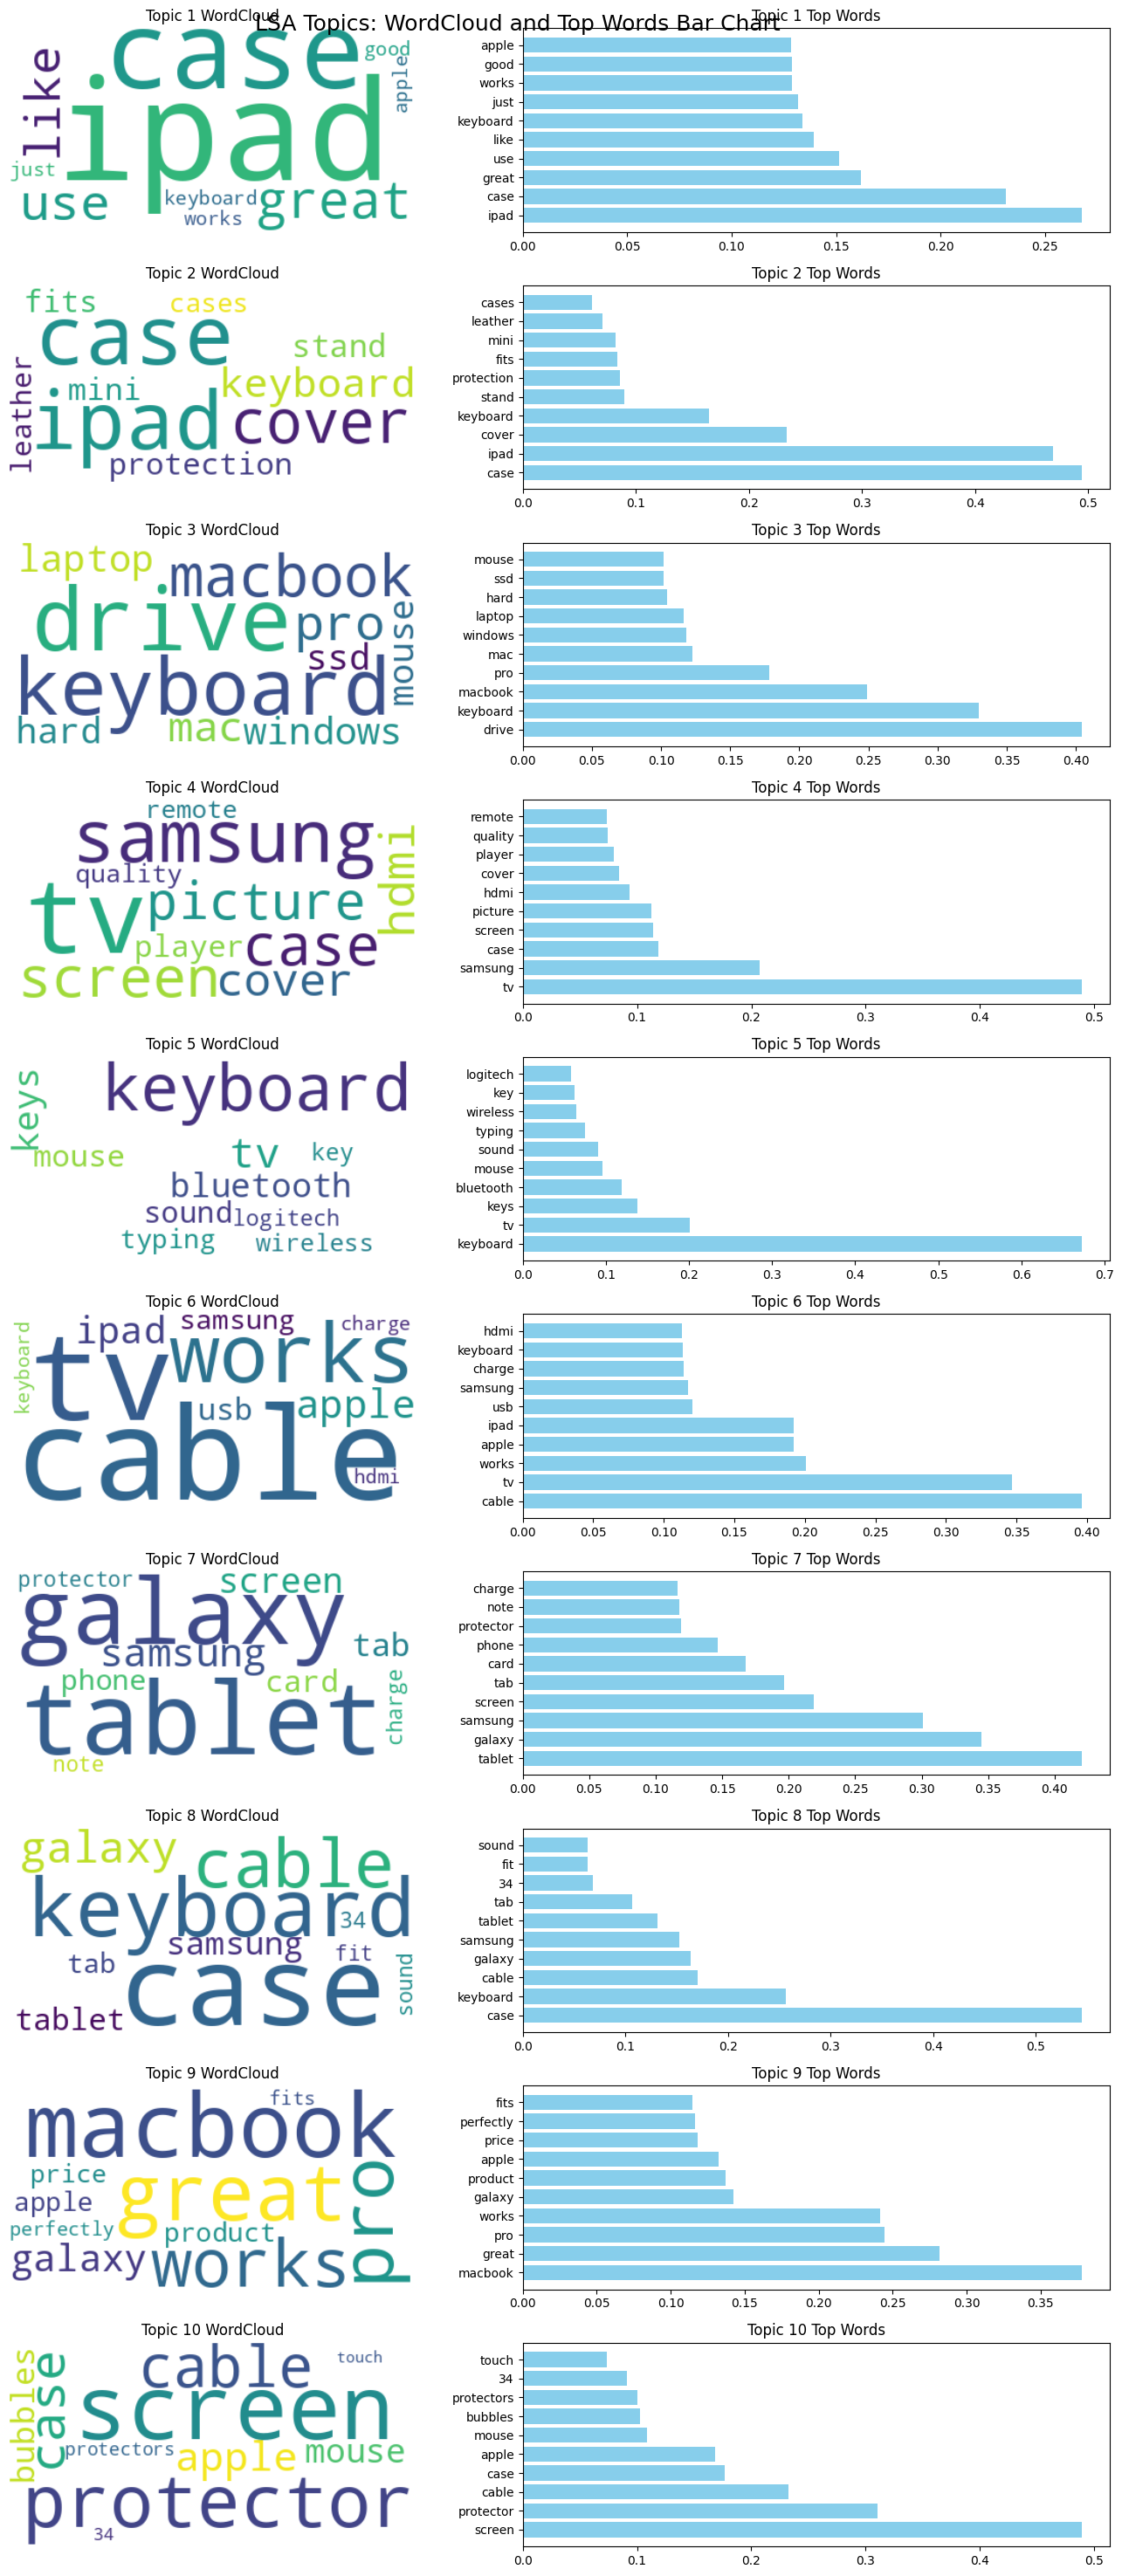

In [ ]:
# Create visualizations for each topic
# One word cloud and one bar chart per topic

# Prepare to plot
fig, axes = plt.subplots(n_topics, 2, figsize=(14, n_topics * 3))
fig.suptitle('LSA Topics: WordCloud and Top Words Bar Chart', fontsize=18)
fig.subplots_adjust(top=0.98, hspace=0.6)

# Loop through each topic
for i, (topic_name, words) in enumerate(topic_terms.items()):
    # Get word weights from the original SVD component
    topic_weights = svd.components_[i]
    top_indices = topic_weights.argsort()[::-1][:10]
    top_words = [terms[idx] for idx in top_indices]
    top_scores = topic_weights[top_indices]

    # WordCloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(
        dict(zip(top_words, top_scores))
    )
    axes[i, 0].imshow(wordcloud, interpolation='bilinear')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"{topic_name} WordCloud")

    # Bar Chart
    axes[i, 1].barh(top_words[::-1], top_scores[::-1], color='skyblue')
    axes[i, 1].set_title(f"{topic_name} Top Words")
    axes[i, 1].invert_yaxis()

plt.tight_layout()
plt.show()


LDA

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.1 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: scipy
    Found existing installatio

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   Topic #                                       Top Keywords
0        0  0.015*"usb" + 0.011*"drive" + 0.010*"battery" ...
1        1  0.016*"case" + 0.013*"ipad" + 0.010*"keyboard"...
2        2  0.018*"sound" + 0.008*"quality" + 0.008*"headp...
3        3  0.010*"tv" + 0.009*"samsung" + 0.008*"one" + 0...
4        4  0.052*"camera" + 0.010*"lens" + 0.009*"cameras...


<ipython-input-1-f41024a10505>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_freq_df, x='Topic', y='Document Count', palette='mako')


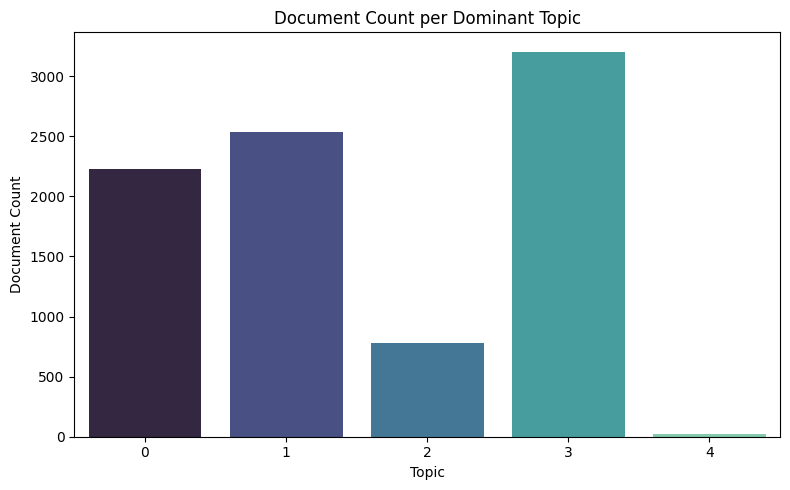

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

# Optional: download stopwords if not already present
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Load dataset
df = pd.read_csv("semantic_tech_10k.csv")  # Make sure this file is in your working directory
text_column = 'review_text'
texts = df[text_column].dropna().astype(str).tolist()

# Text preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

processed_texts = [preprocess(text) for text in texts]

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

# Print topics
topics = lda_model.print_topics(num_words=10)
topics_df = pd.DataFrame(topics, columns=["Topic #", "Top Keywords"])
topics_df.to_csv("lda_topics.csv", index=False)
print(topics_df)

# Generate word clouds for each topic
for i, topic in lda_model.show_topics(formatted=False):
    topic_words = dict(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for Topic {i}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"topic_{i}_wordcloud.png")
    plt.close()

# Topic distribution across documents
doc_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
topic_counts = Counter(doc_topics)
topic_freq_df = pd.DataFrame.from_dict(topic_counts, orient='index').reset_index()
topic_freq_df.columns = ['Topic', 'Document Count']

# Bar plot of topic distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=topic_freq_df, x='Topic', y='Document Count', palette='mako')
plt.title('Document Count per Dominant Topic')
plt.tight_layout()
plt.savefig("topic_distribution.png")
plt.show()


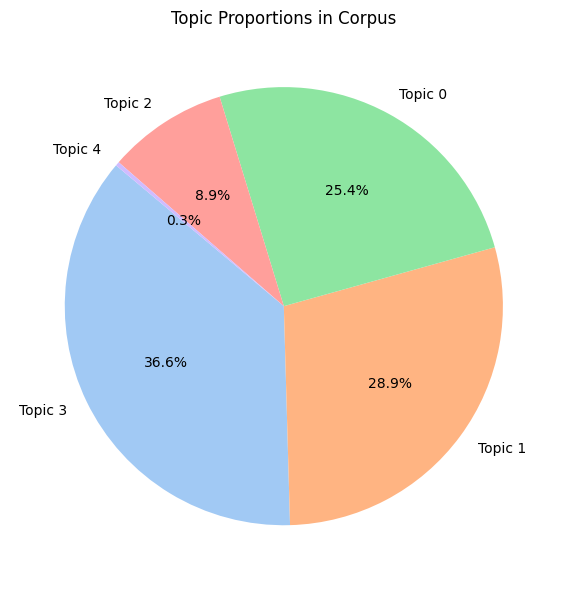

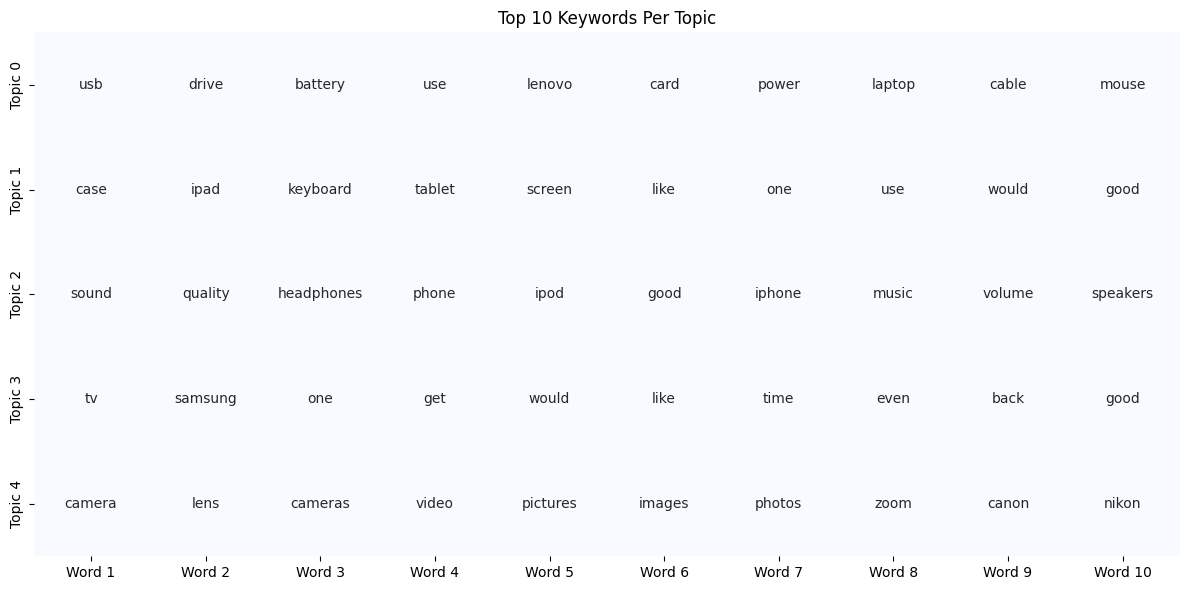


📄 Sample Documents per Topic:

🟦 Topic 0 Example Docs:
- This is a very novel product idea.  A lot of digital cameras do not come with WiFi built in.  That includes the high end models.  This can enable it on your device if you would like.Setup wasn't too b...
- I bought this SSD as a replacement for my Lenovo Y580 laptop. The original laptop configuration was a 1TB physical drive and a 16GB msata SSD. I have updated the configuration to a 2.5 Samsung 256GB S...
- What can I say about this product, it's a battery. It works well with my Dell E1705. Dell laptops are very particular about which batteries they recognize. I've bought a couple in the past that the bi...

🟦 Topic 1 Example Docs:
- I ordered this for a Lenovo ideapad U310 which is an ultrabook, it fits perfectly.  Great case, well made case....
- Original Review: It worked for my Galaxy 2.0 7 inch tablet. The construction was better than I thought it would be.  Nice charger.Update: 02/18/2014 :  This charger when from 5 stars

In [ ]:
# --- Pie Chart of Topic Proportions ---
plt.figure(figsize=(6, 6))
plt.pie(topic_freq_df['Document Count'], labels=[f'Topic {i}' for i in topic_freq_df['Topic']],
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Topic Proportions in Corpus')
plt.tight_layout()
plt.savefig("topic_proportions_piechart.png")
plt.show()


# --- Heatmap of Top Keywords in Each Topic ---
# Extract top words per topic
topic_keywords = []
for i in range(5):  # num_topics
    words_probs = lda_model.show_topic(i, topn=10)
    topic_keywords.append([word for word, _ in words_probs])

# --- Heatmap of Top Keywords in Each Topic (fixed) ---
plt.figure(figsize=(12, 6))
sns.heatmap([[1]*10]*5, annot=heatmap_df.values, fmt='', cbar=False, cmap='Blues',
            xticklabels=heatmap_df.columns, yticklabels=heatmap_df.index)
plt.title("Top 10 Keywords Per Topic")
plt.tight_layout()
plt.savefig("topic_keywords_heatmap.png")
plt.show()



# --- Print 3 Sample Documents per Topic ---
print("\n" + "="*50)
print("📄 Sample Documents per Topic:")
print("="*50)
for topic_id in range(5):
    print(f"\n🟦 Topic {topic_id} Example Docs:")
    count = 0
    for i, doc in enumerate(corpus):
        dominant_topic = max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0]
        if dominant_topic == topic_id:
            print(f"- {texts[i][:200]}...")  # Print first 200 characters
            count += 1
        if count == 3:
            break


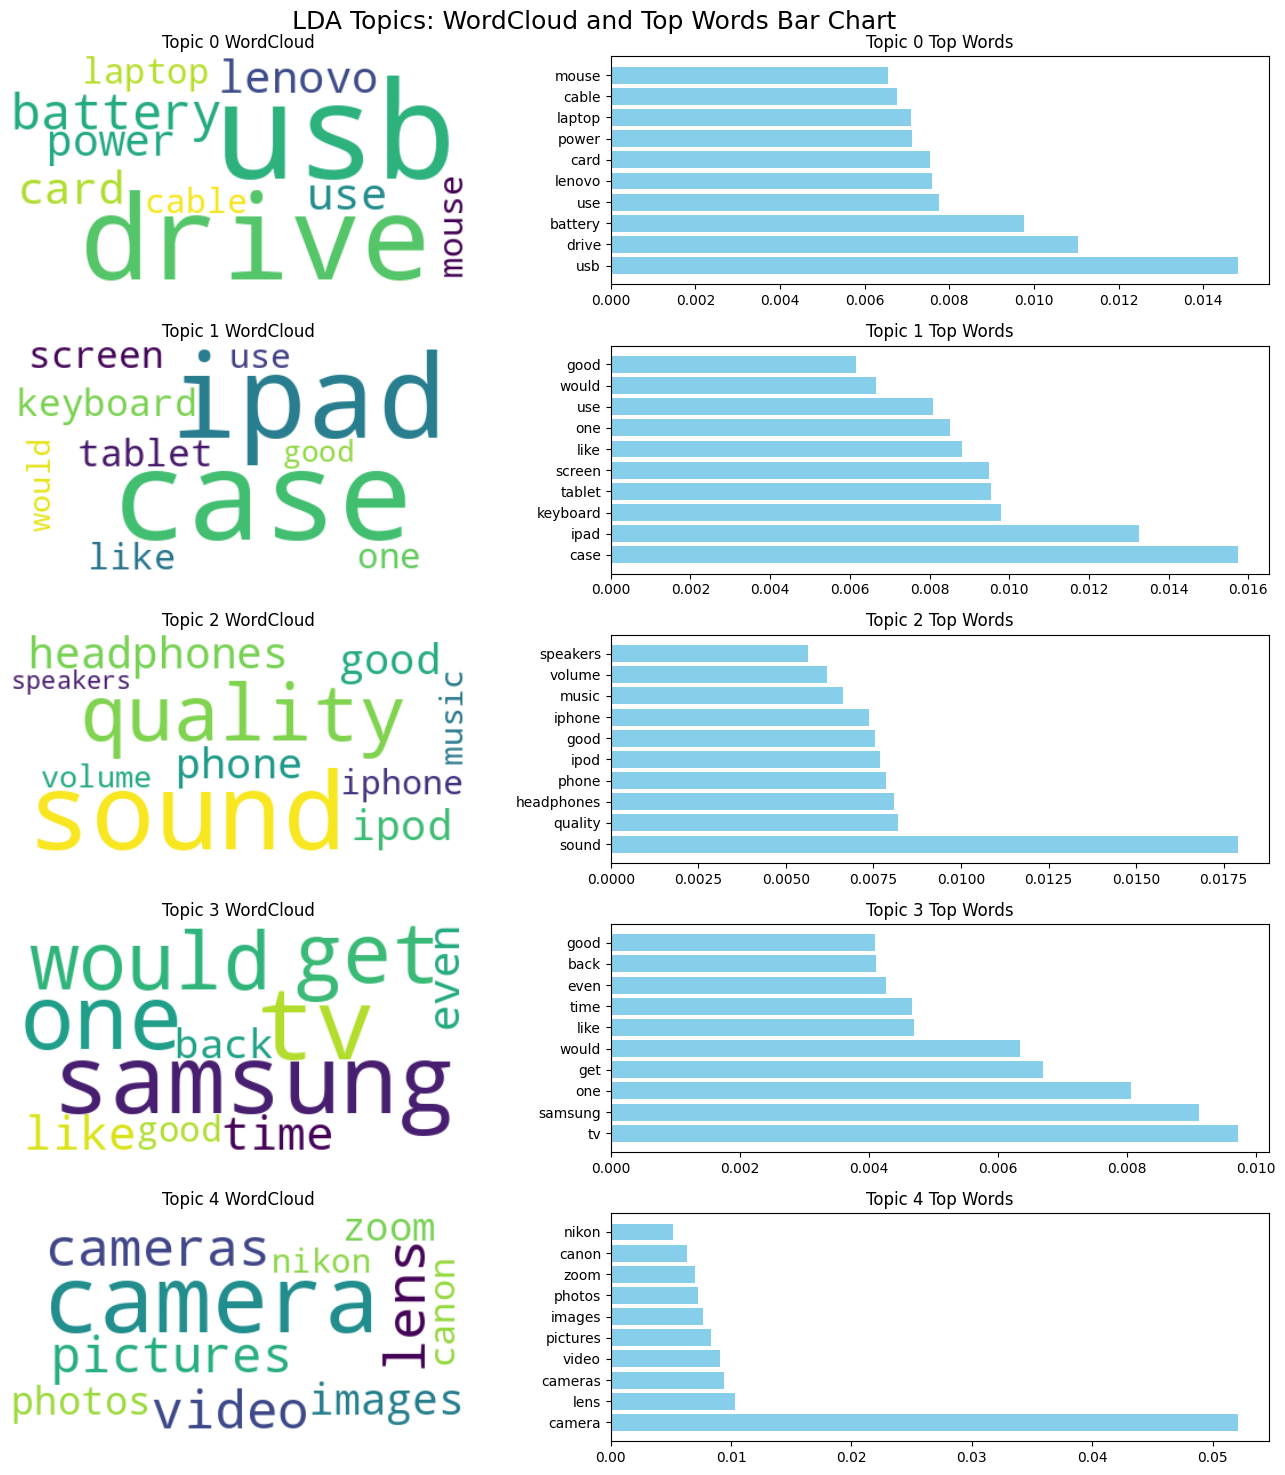

In [ ]:
# Get number of topics
n_topics = lda_model.num_topics

# Prepare to plot WordCloud + Bar Chart side-by-side
fig, axes = plt.subplots(n_topics, 2, figsize=(14, n_topics * 3))
fig.suptitle('LDA Topics: WordCloud and Top Words Bar Chart', fontsize=18)
fig.subplots_adjust(top=0.95, hspace=0.5)

for i in range(n_topics):
    # Get topic word distributions
    topic_words = lda_model.show_topic(i, topn=10)
    top_words = [word for word, _ in topic_words]
    top_scores = [score for _, score in topic_words]

    # WordCloud
    wordcloud = WordCloud(width=400, height=200, background_color='white') \
        .generate_from_frequencies(dict(topic_words))
    axes[i, 0].imshow(wordcloud, interpolation='bilinear')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Topic {i} WordCloud")

    # Horizontal Bar Chart
    axes[i, 1].barh(top_words[::-1], top_scores[::-1], color='skyblue')
    axes[i, 1].set_title(f"Topic {i} Top Words")
    axes[i, 1].invert_yaxis()

plt.tight_layout()
plt.savefig("topic_wordcloud_barchart_grid.png")
plt.show()


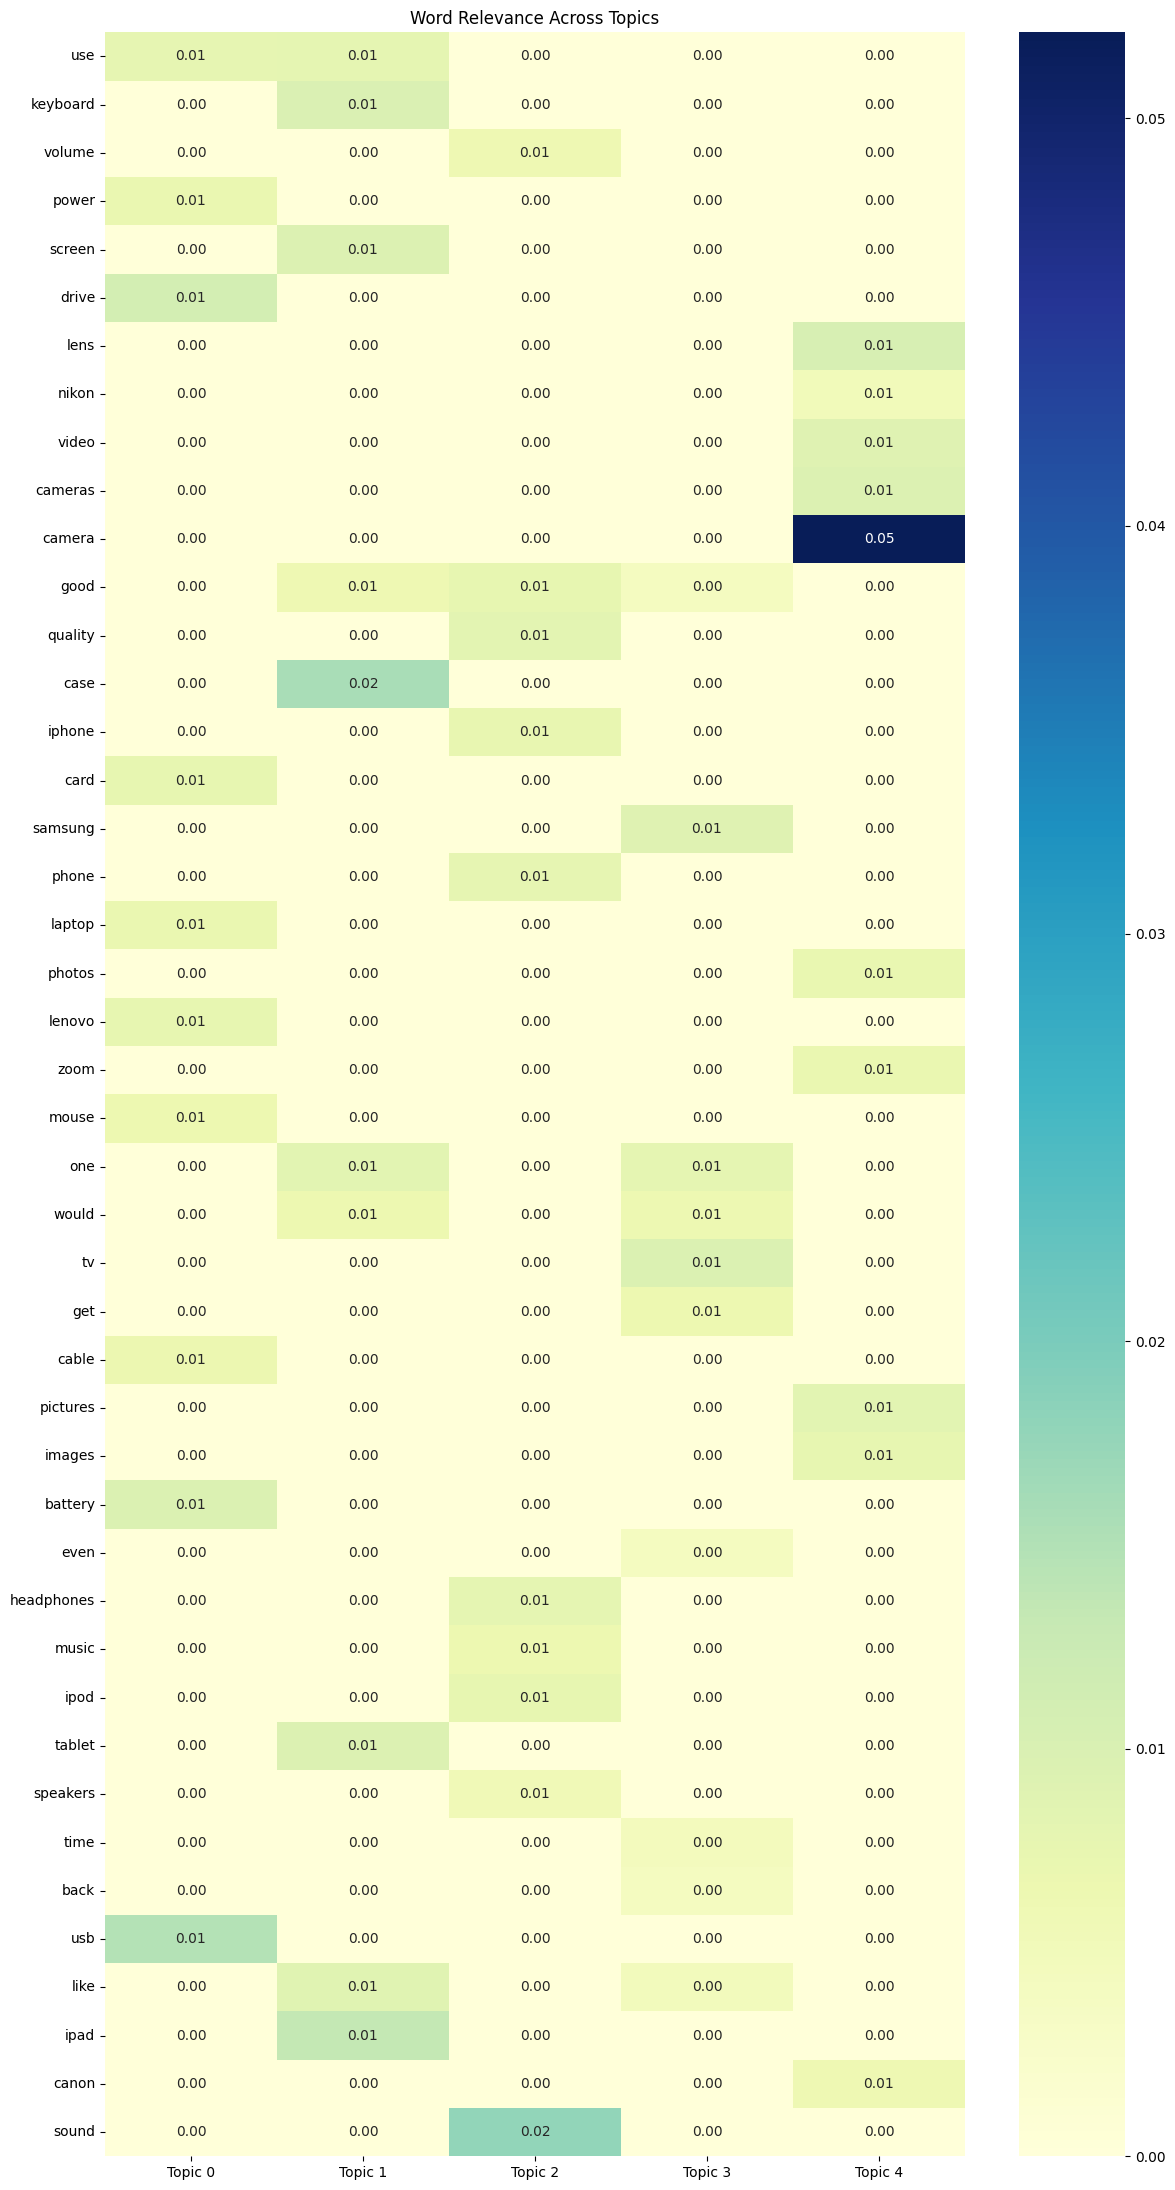

In [ ]:
# Create a matrix of word probabilities per topic
topn = 10
all_words = []
topic_word_dict = {}

for topic_id in range(n_topics):
    words_probs = lda_model.show_topic(topic_id, topn=topn)
    topic_word_dict[f'Topic {topic_id}'] = dict(words_probs)
    all_words.extend([w for w, _ in words_probs])

unique_words = list(set(all_words))
heatmap_data = []

for word in unique_words:
    row = []
    for topic_id in range(n_topics):
        score = topic_word_dict[f'Topic {topic_id}'].get(word, 0)
        row.append(score)
    heatmap_data.append(row)

df_heatmap = pd.DataFrame(heatmap_data, columns=[f'Topic {i}' for i in range(n_topics)], index=unique_words)

plt.figure(figsize=(12, len(unique_words) * 0.5))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Word Relevance Across Topics")
plt.tight_layout()
plt.savefig("word_topic_heatmap.png")
plt.show()


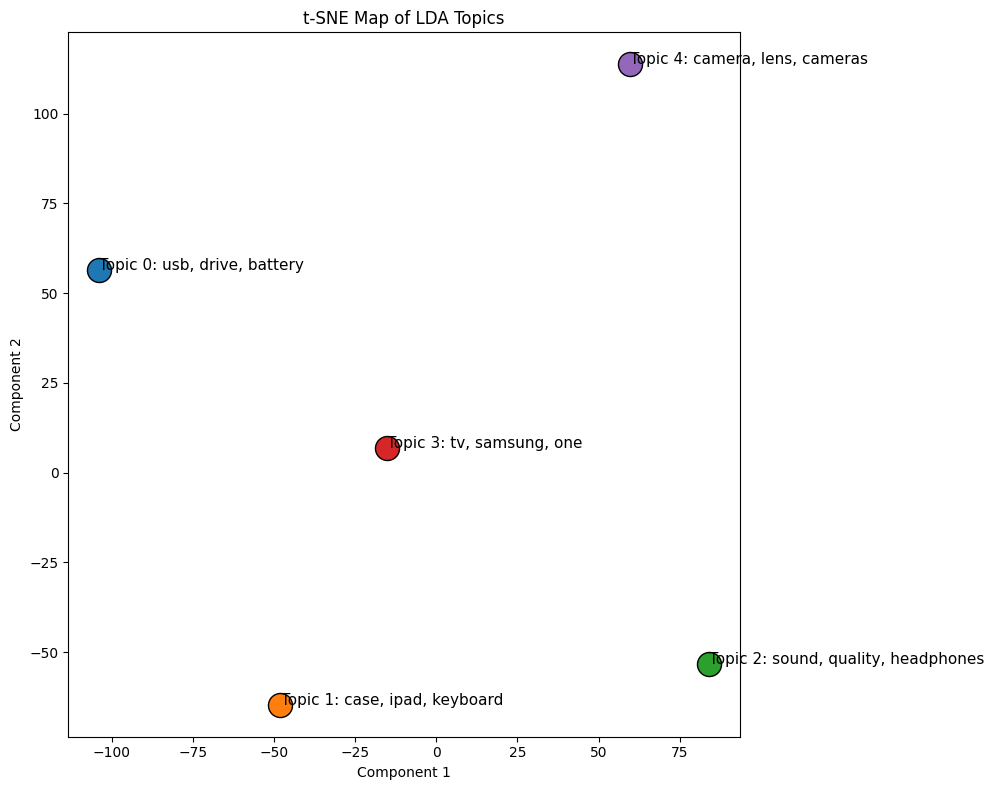

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Number of topics in your LDA model
n_topics = lda_model.num_topics

# Convert each topic (sparse word distribution) into a dense vector
dense_matrix = []

vocab_size = len(dictionary)
for topic_id in range(n_topics):
    dense_vec = np.zeros(vocab_size)
    for word_id, prob in lda_model.get_topic_terms(topic_id, topn=vocab_size):
        dense_vec[word_id] = prob
    dense_matrix.append(dense_vec)

dense_matrix_np = np.array(dense_matrix)

# Use perplexity < n_topics
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
topic_coords = tsne.fit_transform(dense_matrix_np)

# Prepare labels
topic_labels = []
for i in range(n_topics):
    words = [word for word, _ in lda_model.show_topic(i, topn=3)]
    label = f"Topic {i}: " + ", ".join(words)
    topic_labels.append(label)

# Plot
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(topic_coords):
    plt.scatter(x, y, s=300, edgecolors='black')
    plt.text(x + 0.01, y + 0.01, topic_labels[i], fontsize=11)
plt.title("t-SNE Map of LDA Topics")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.savefig("topic_tsne_map.png")
plt.show()


BIRDTopic

In [ ]:
!pip install bertopic
!pip install umap-learn hdbscan sentence-transformers
!pip install bertopic umap-learn hdbscan sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
%%capture
!pip uninstall -y numpy
!pip install numpy==1.24.4 scipy==1.11.1
!pip install bertopic umap-learn hdbscan sentence-transformers


In [ ]:
# 🧰 Step 1: Install required packages (uncomment these lines if not installed)
!pip install bertopic umap-learn hdbscan sentence-transformers

# ✅ Step 2: Imports
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# ✅ Step 3: Load and prepare your dataset
df = pd.read_csv("semantic_tech_10k.csv")  # make sure the file is in the same directory
texts = df["review_text"].dropna().astype(str).tolist()

# ✅ Step 4: Use a custom SentenceTransformer model (optional but recommended)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# ✅ Step 5: Fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="english", verbose=True)
topics, probs = topic_model.fit_transform(texts)

# ✅ Step 6: Print topic info
print("📊 Topic Overview:")
print(topic_model.get_topic_info().head(10))  # Top 10 topics

# ✅ Step 7: Visualize topic relationships
topic_model.visualize_topics().show()

# ✅ Step 8: Visualize top words per topic
topic_model.visualize_barchart(top_n_topics=10).show()

# ✅ Step 9: Visualize topic similarity as heatmap
topic_model.visualize_heatmap().show()

# ✅ Step 10: Visualize topic hierarchy
topic_model.visualize_hierarchy().show()

# ✅ Step 11: Show example documents for a specific topic (e.g., topic 1)
print("\n📄 Sample documents for Topic 1:")
for doc in topic_model.get_representative_docs(1)[:3]:
    print("—", doc[:300], "\n")

# ✅ Step 12: Save model (optional)
# topic_model.save("bertopic_model")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-04-01 19:59:14,132 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/274 [00:00<?, ?it/s]

2025-04-01 19:59:30,547 - BERTopic - Embedding - Completed ✓
2025-04-01 19:59:30,548 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-01 20:00:06,834 - BERTopic - Dimensionality - Completed ✓
2025-04-01 20:00:06,835 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-01 20:00:07,115 - BERTopic - Cluster - Completed ✓
2025-04-01 20:00:07,133 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-01 20:00:07,971 - BERTopic - Representation - Completed ✓


📊 Topic Overview:
   Topic  Count                           Name  \
0     -1   2106               -1_the_to_it_and   
1      0    508           0_ipad_case_cover_it   
2      1    407           1_player_dvd_ray_blu   
3      2    338   2_headphones_these_ear_sound   
4      3    272       3_case_tab_galaxy_tablet   
5      4    270       4_tv_picture_samsung_set   
6      5    269   5_monitor_cable_display_hdmi   
7      6    227     6_tablet_android_screen_is   
8      7    222        7_card_sd_sandisk_cards   
9      8    216  8_mouse_scroll_wheel_logitech   

                                      Representation  \
0   [the, to, it, and, is, this, my, that, of, with]   
1  [ipad, case, cover, it, the, stand, is, for, a...   
2  [player, dvd, ray, blu, netflix, tv, samsung, ...   
3  [headphones, these, ear, sound, headset, they,...   
4  [case, tab, galaxy, tablet, cover, 10, the, fo...   
5  [tv, picture, samsung, set, the, and, this, is...   
6  [monitor, cable, display, hdmi, adap


📄 Sample documents for Topic 1:
— ****Aug 12 2010 Update**** The fixed/refurbished player was fine at first but again started spitting out discs that played fine on other DVD players and -- even worse -- would just say "Please Wait" for a long time before being ready to use.  The "Please Wait" period got longer and longer and now th 

— This is my second Samsung Blu-ray player.  It does Netflix very well, that is not an issue.I did all of the firmware updates for this player.  Sometimes it doesn't like a Blu-Ray and then will announce that I need to download an update to the player.  Well my updates are current so there is nothing  

— I plan on keeping this review up to date, so as things change I will keep adding to it.  I will also try to answer any questions in comments.April 2, 2010I received this player from Amazon today.  Within the first hour I had it hooked up to my home theater system, connected to my wi-fi network, upda 



In [ ]:
# 🎨 All BERTopic Visualizations in One Cell

# Intertopic distance map (2D UMAP)
fig1 = topic_model.visualize_topics()
fig1.show()

# Top words bar chart
fig2 = topic_model.visualize_barchart(top_n_topics=10)
fig2.show()

# Topic similarity heatmap
fig3 = topic_model.visualize_heatmap()
fig3.show()

# Topic hierarchy dendrogram
fig4 = topic_model.visualize_hierarchy()
fig4.show()


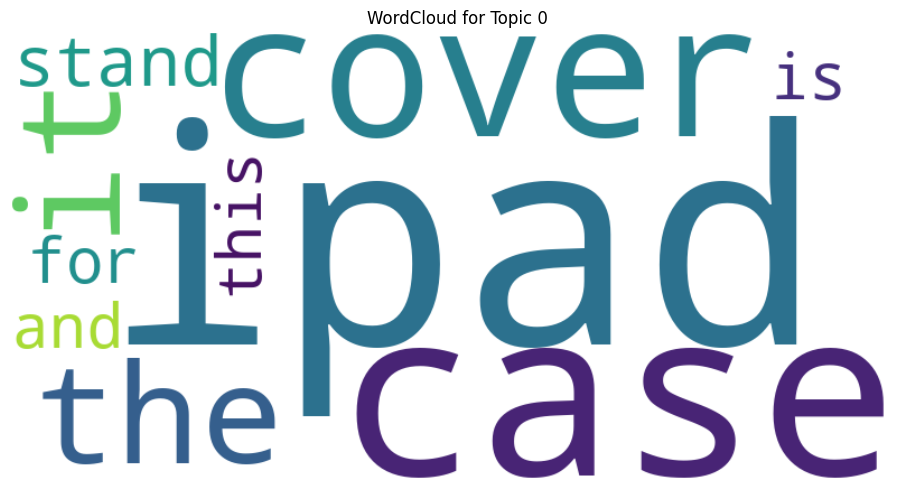

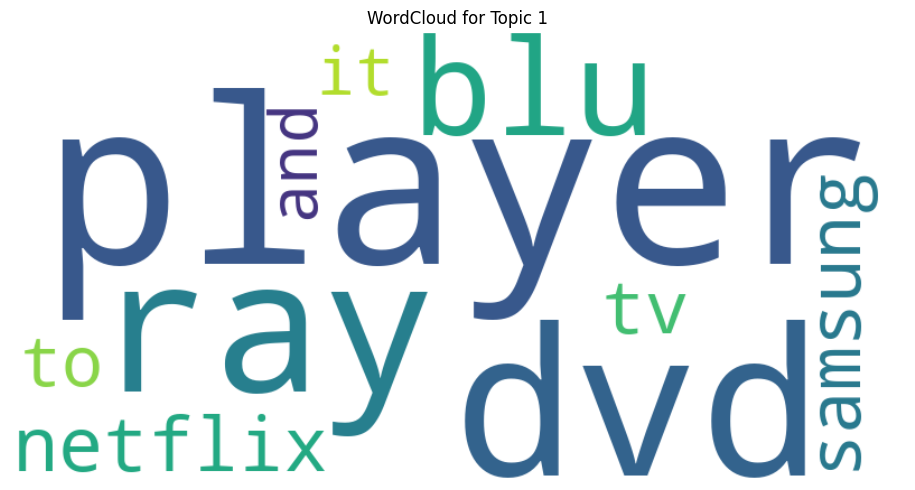

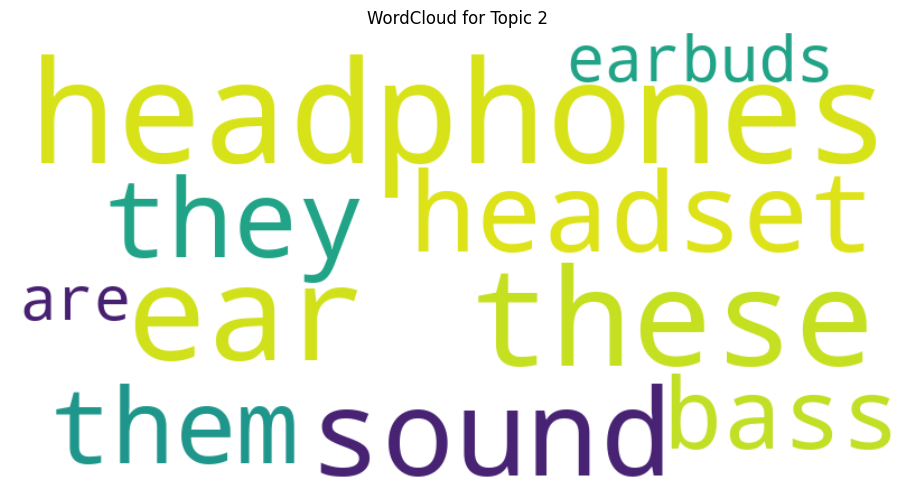

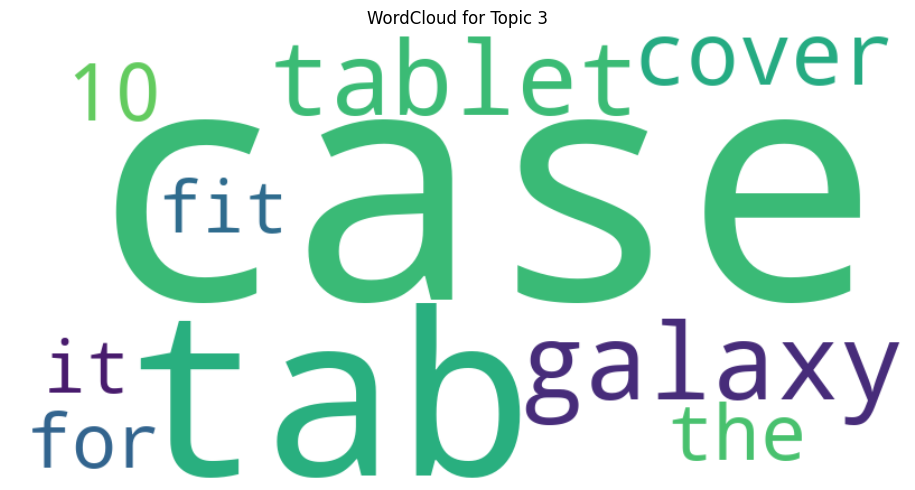

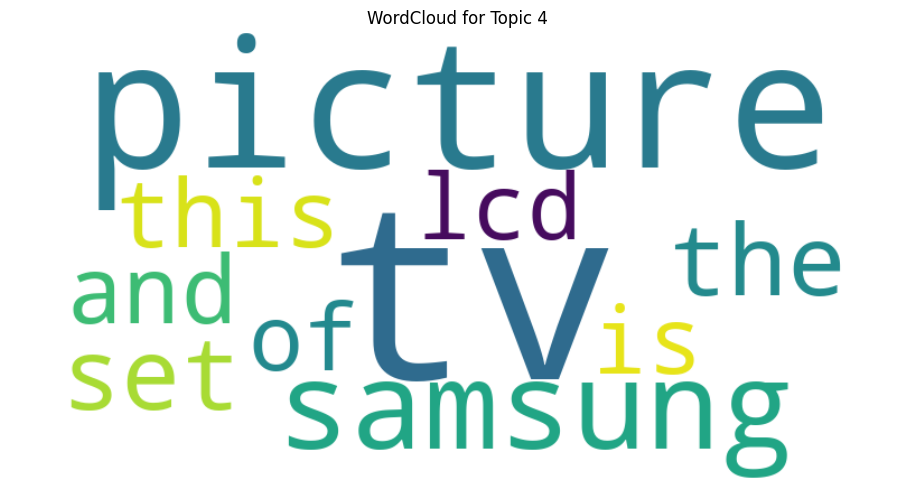

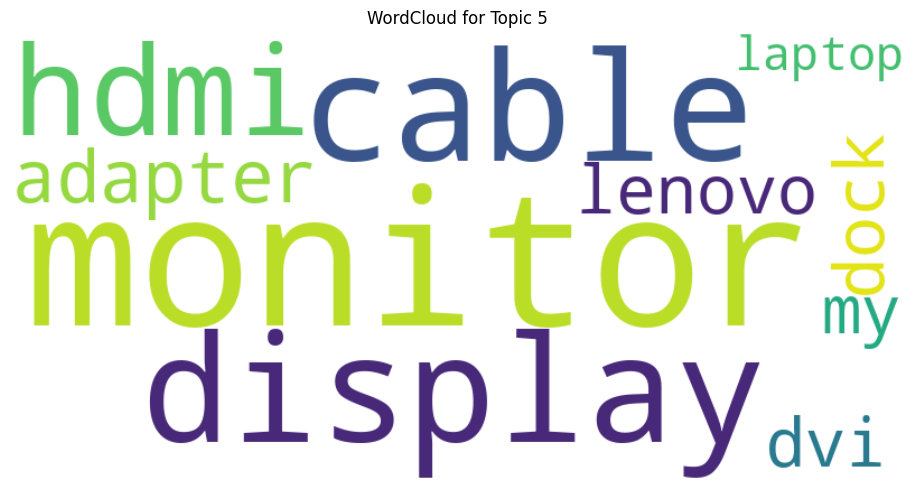

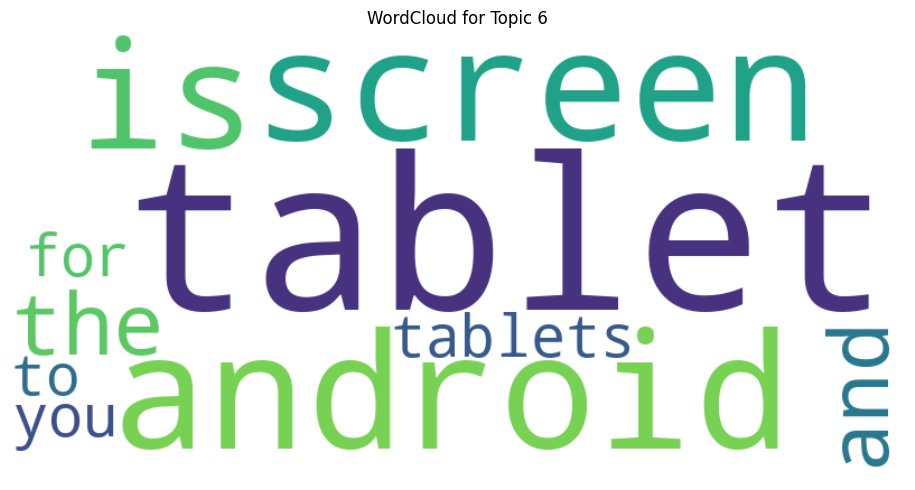

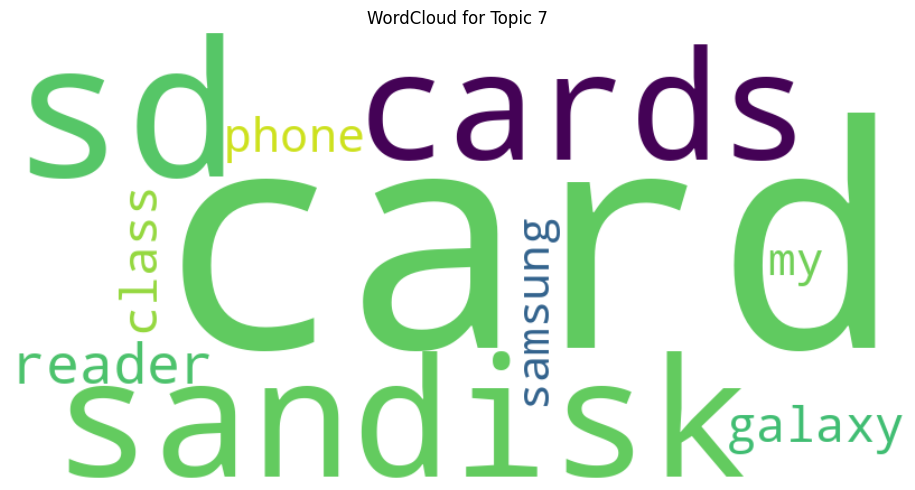

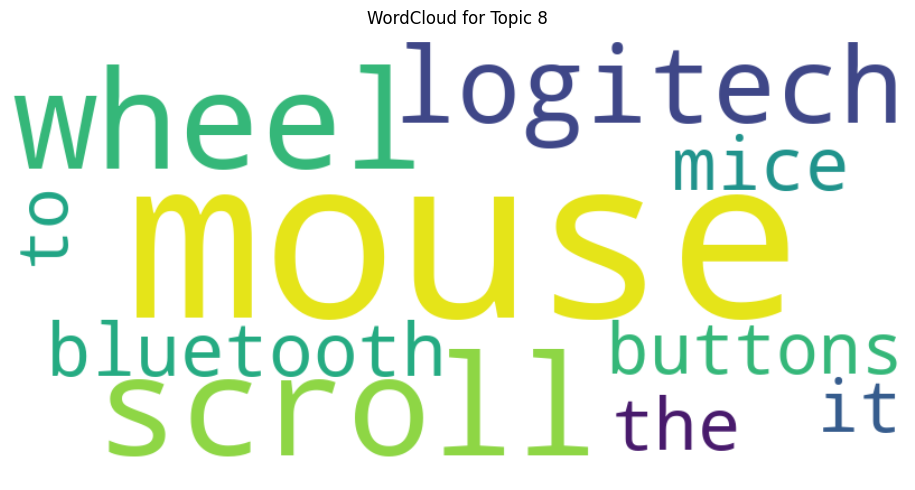

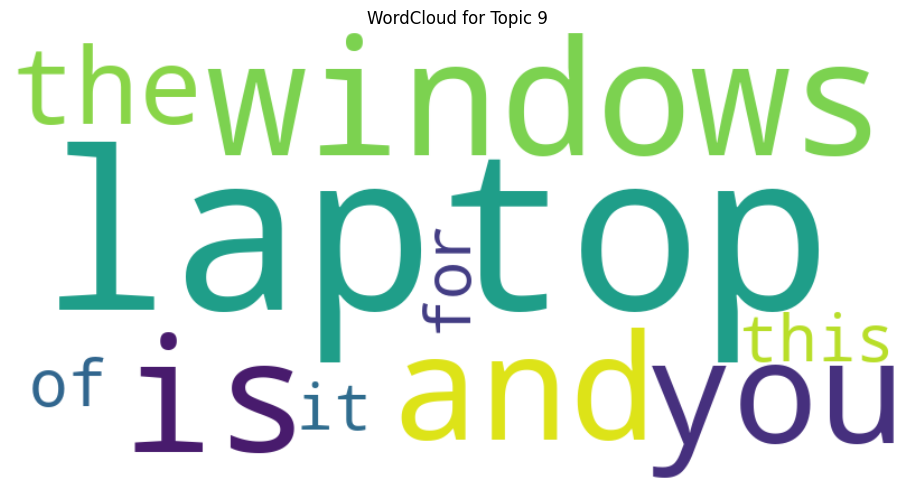

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 🔢 How many topics to show (or use topic_model.get_topic_info())
n_topics_to_plot = 10

for topic_id in range(n_topics_to_plot):
    topic = topic_model.get_topic(topic_id)
    if not topic:
        continue

    word_freq = dict(topic)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic {topic_id}")
    plt.tight_layout()
    plt.show()

    # Optional: save image
    # wc.to_file(f"topic_{topic_id}_wordcloud.png")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


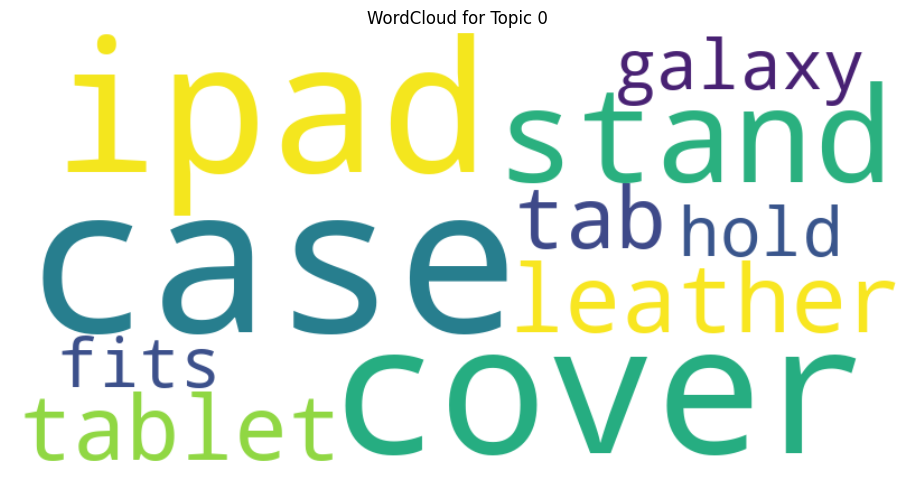

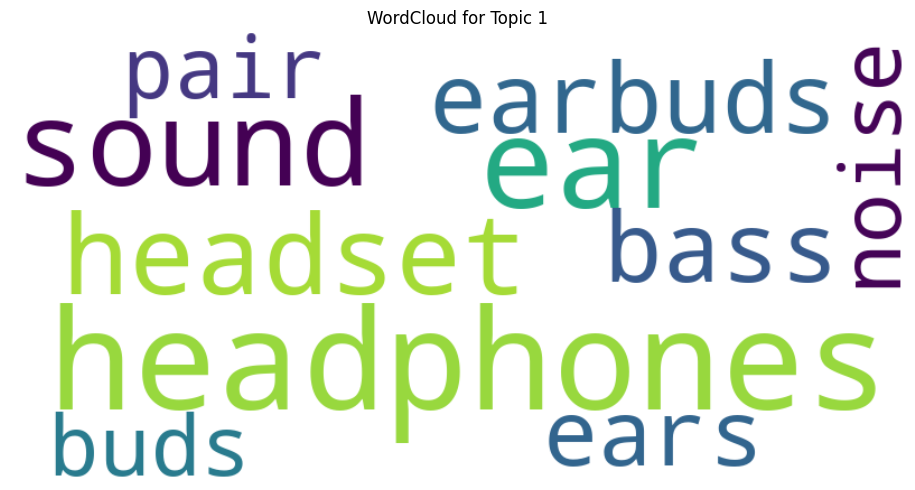

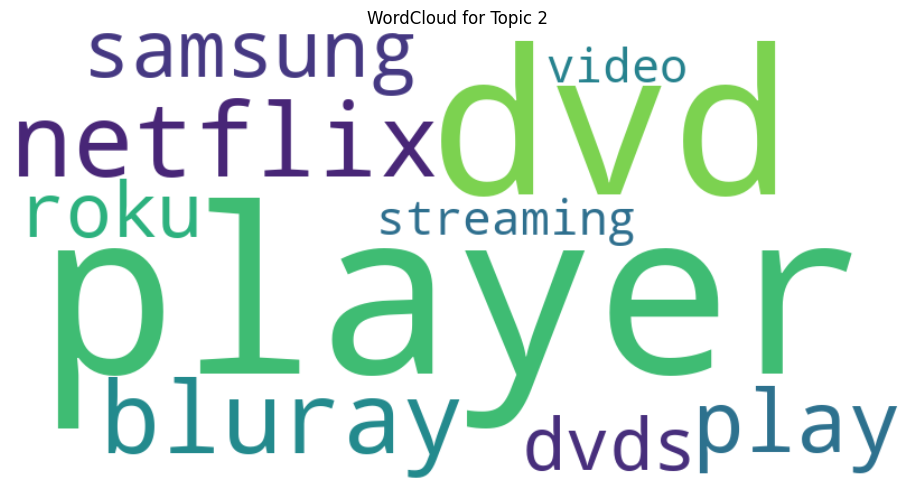

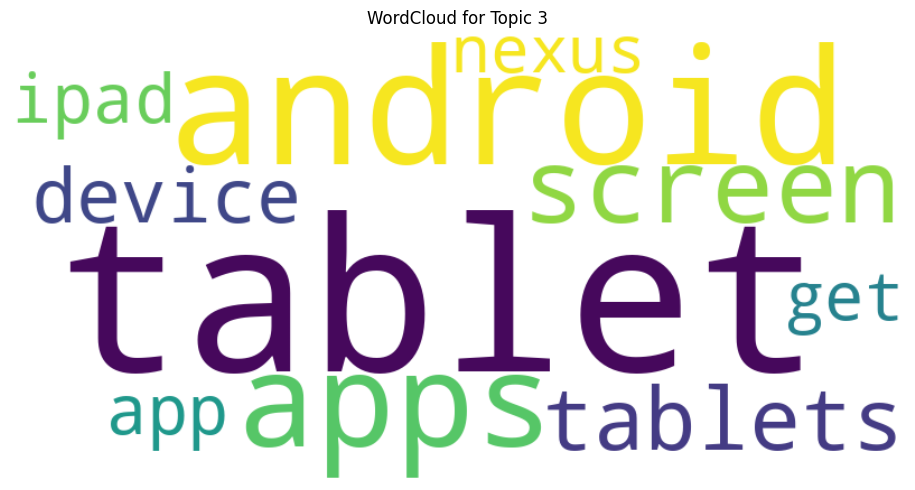

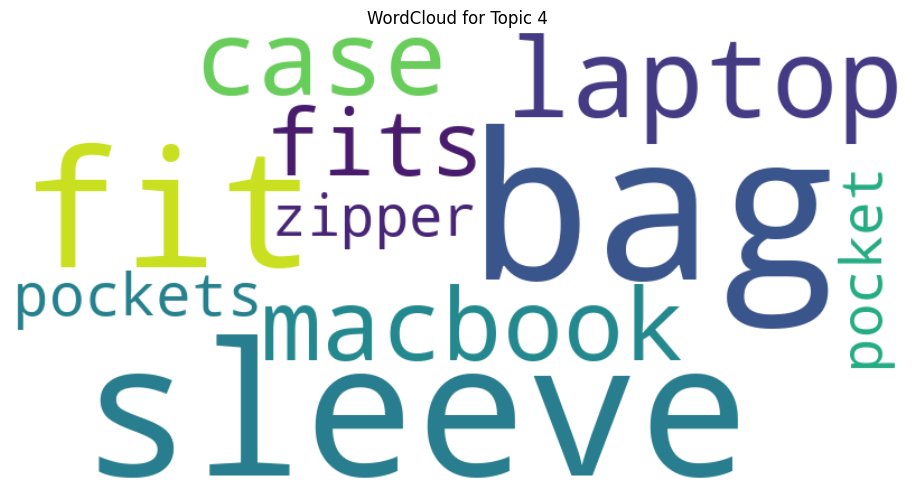

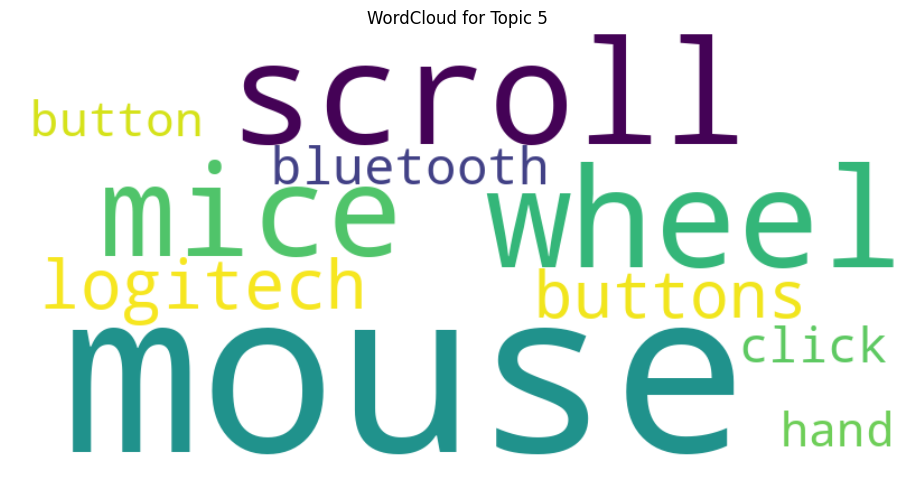

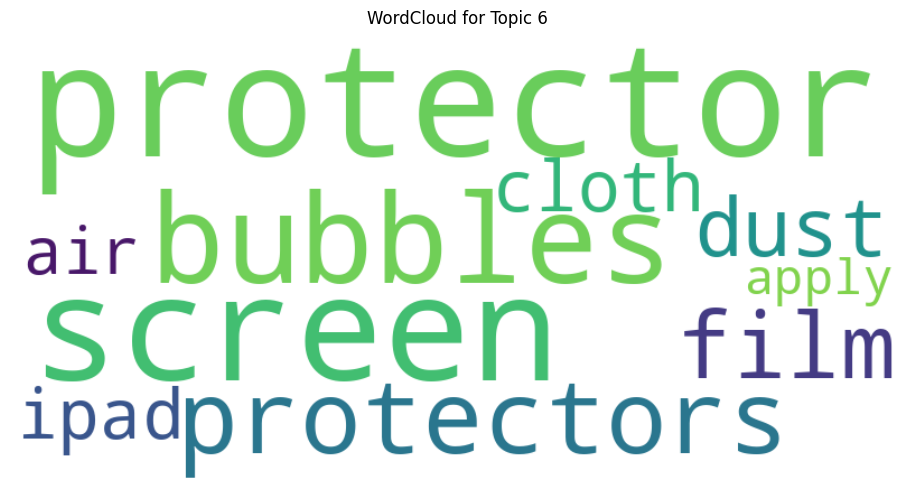

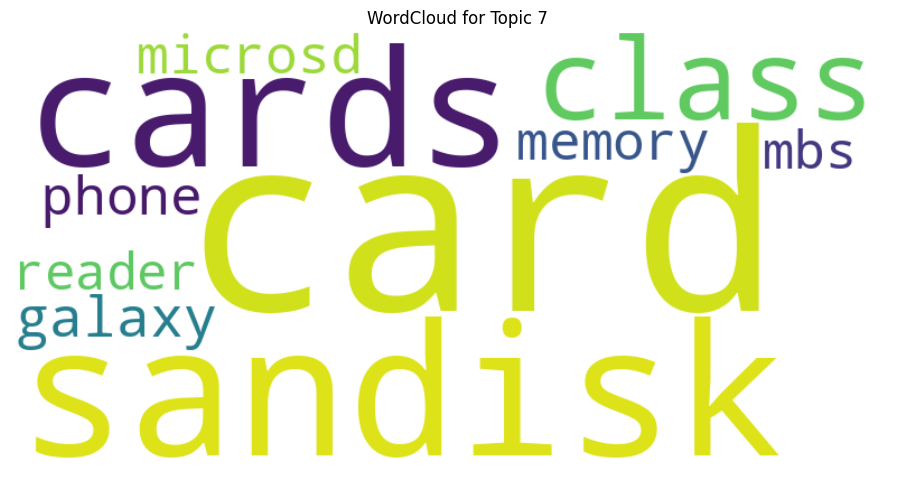

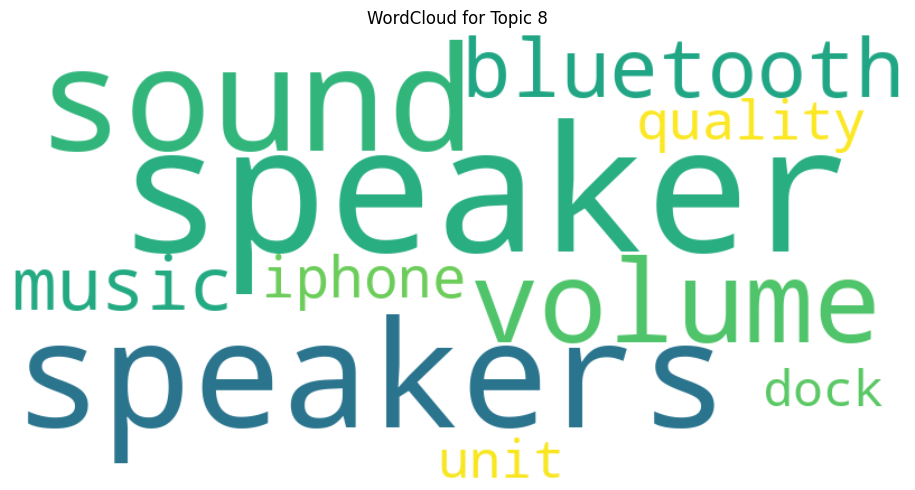

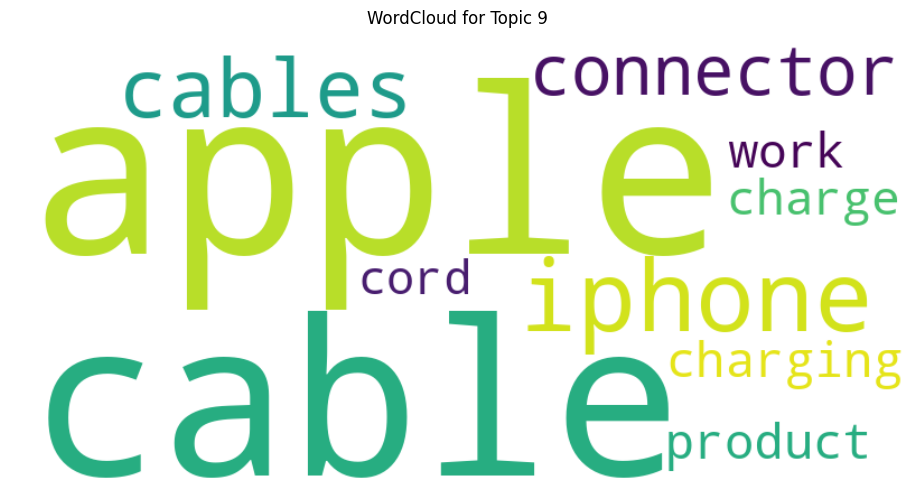

In [ ]:
# 📦 Install dependencies if not done
# !pip install -U bertopic umap-learn hdbscan sentence-transformers wordcloud

# ✅ One cell for preprocessing + modeling + visualization
import pandas as pd
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ✅ Load and clean dataset
df = pd.read_csv("semantic_tech_10k.csv")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)          # remove punctuation
    text = re.sub(r"\d+", "", text)              # remove numbers
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df["cleaned_text"] = df["review_text"].astype(str).apply(clean_text)
df["cleaned_text"].to_csv("cleaned_reviews.csv", index=False)

# ✅ Create BERTopic model
texts = df["cleaned_text"].dropna().tolist()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, language="english")
topics, probs = topic_model.fit_transform(texts)

# ✅ Visualizations
topic_model.visualize_topics().show()
topic_model.visualize_barchart(top_n_topics=10).show()
topic_model.visualize_heatmap().show()
topic_model.visualize_hierarchy().show()

# ✅ WordClouds for Top Topics
n_topics_to_plot = 10
for topic_id in range(n_topics_to_plot):
    topic = topic_model.get_topic(topic_id)
    if not topic:
        continue
    word_freq = dict(topic)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic {topic_id}")
    plt.tight_layout()
    plt.show()


NMF

🟦 Topic 0: samsung | screen | player | unit | picture | time | amazon | work | problem | support
🟦 Topic 1: ipad | case | cover | like | stand | screen | protection | leather | fits | mini
🟦 Topic 2: drive | hard | ssd | windows | usb | drives | computer | laptop | external | sata
🟦 Topic 3: battery | lenovo | laptop | thinkpad | life | original | hours | fit | replacement | fits
🟦 Topic 4: usb | charge | charger | phone | power | device | charging | iphone | adapter | port
🟦 Topic 5: tablet | galaxy | tab | samsung | case | note | fit | great | fits | screen
🟦 Topic 6: keyboard | mouse | keys | use | bluetooth | logitech | laptop | key | windows | wireless
🟦 Topic 7: cable | hdmi | cables | works | monitor | adapter | apple | connect | work | fine
🟦 Topic 8: sound | quality | headphones | good | great | iphone | speakers | music | volume | speaker
🟦 Topic 9: card | camera | memory | cards | reader | phone | sandisk | works | galaxy | pictures


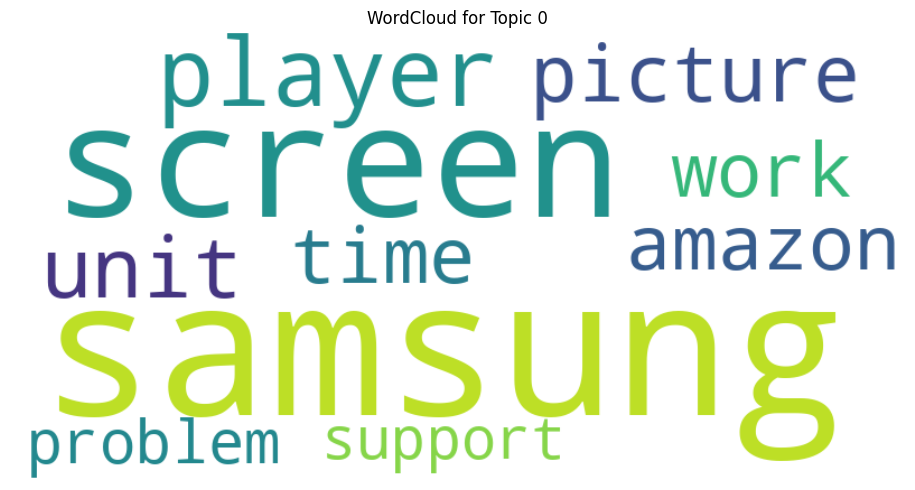

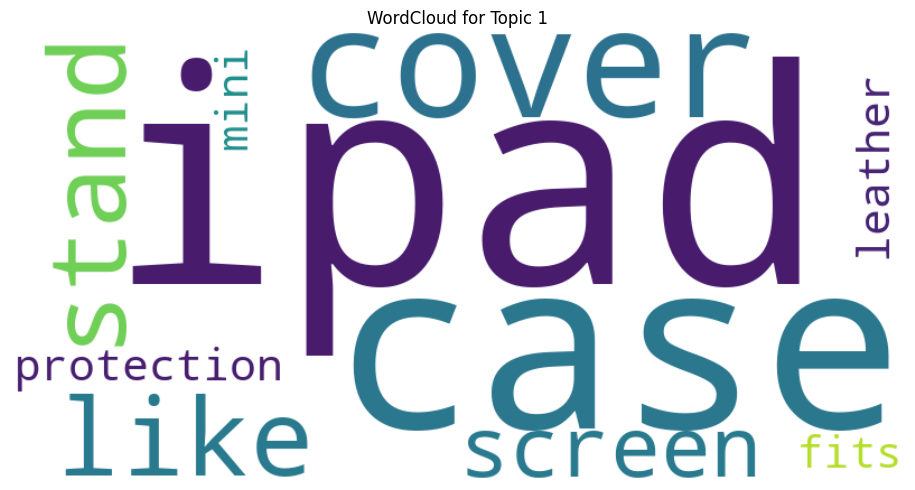

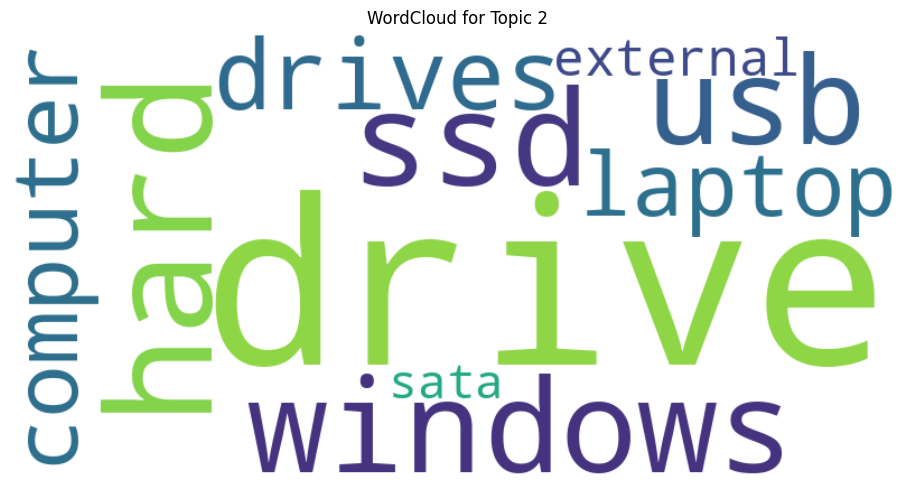

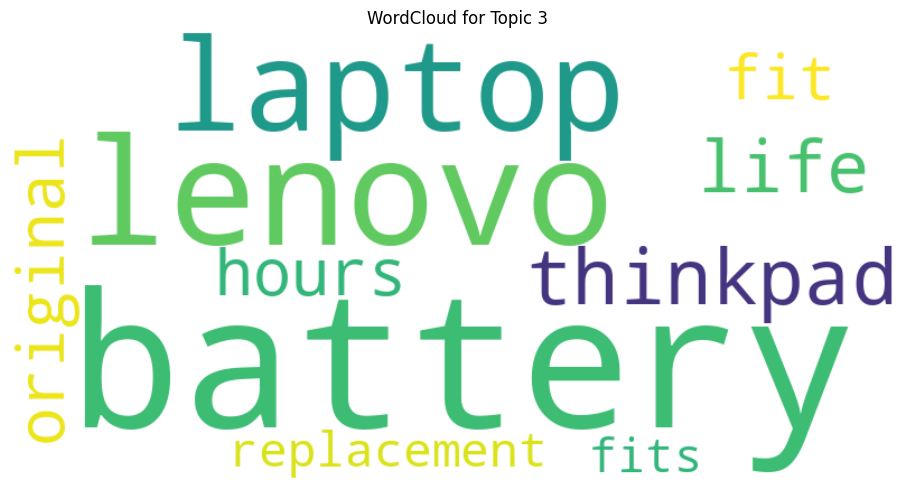

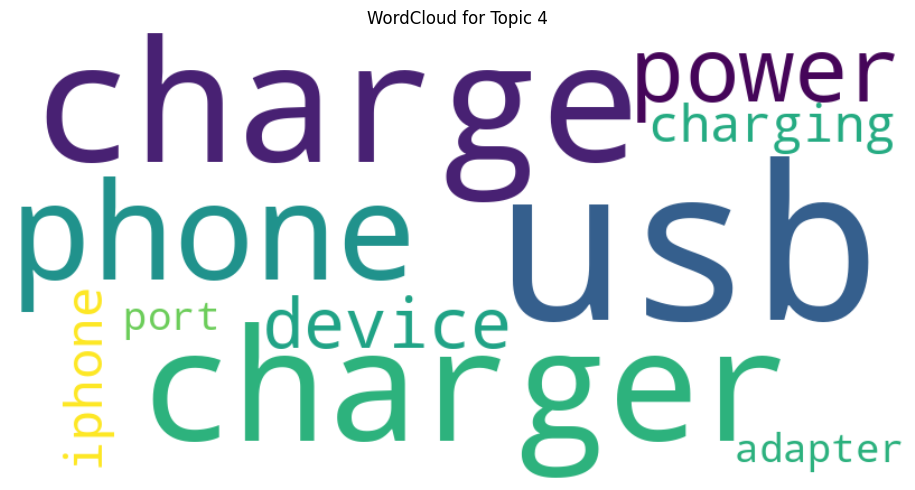

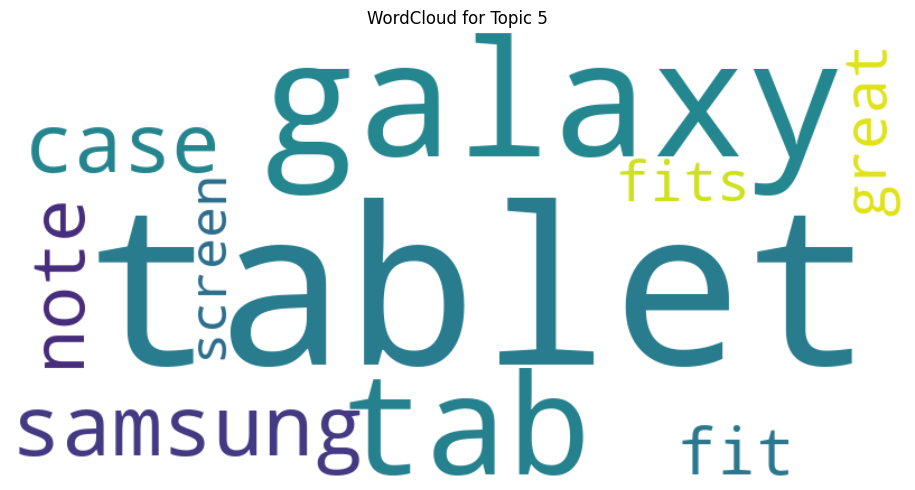

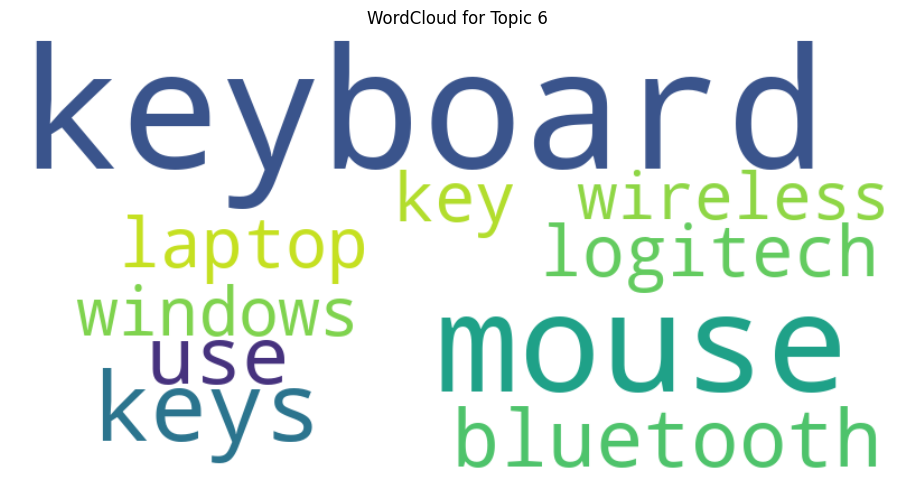

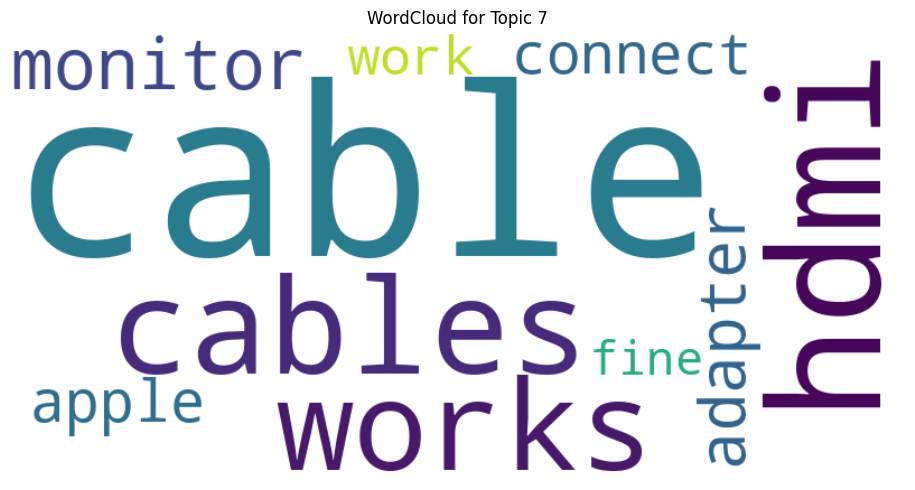

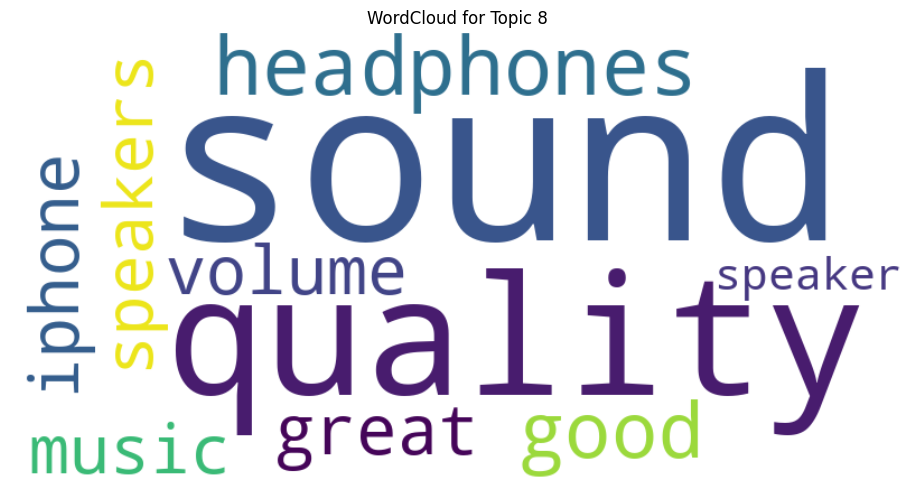

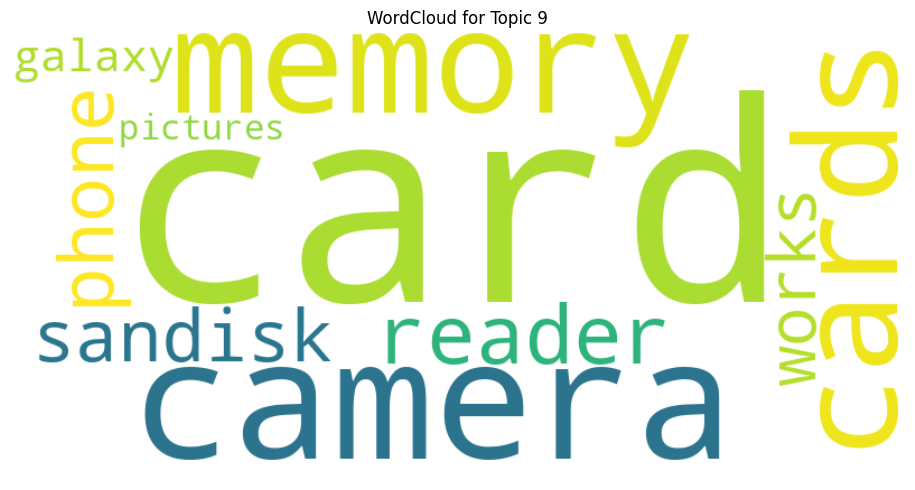

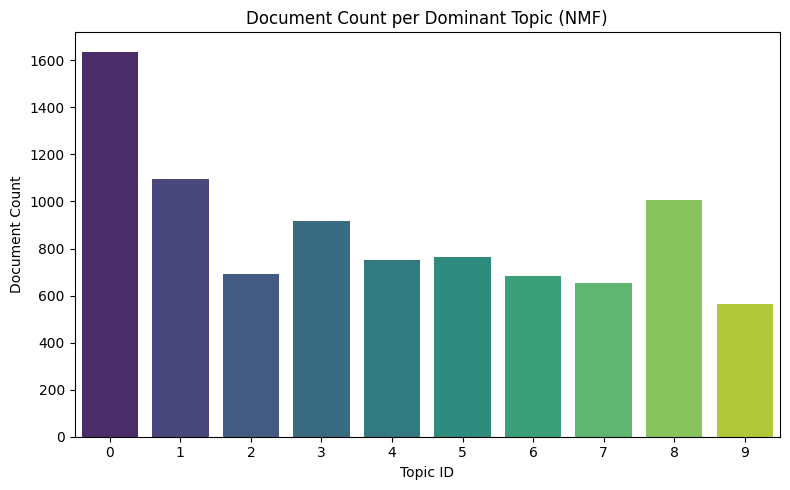

In [ ]:
# ✅ Install if needed
!pip install wordcloud

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# ✅ Load cleaned dataset
texts = pd.read_csv("cleaned_reviews.csv")["cleaned_text"].dropna().tolist()

# ✅ TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
tfidf = vectorizer.fit_transform(texts)
terms = vectorizer.get_feature_names_out()

# ✅ Run NMF
n_topics = 10
nmf_model = NMF(n_components=n_topics, random_state=42)
W = nmf_model.fit_transform(tfidf)
H = nmf_model.components_

# ✅ Show Top Words per Topic
topn = 10
topic_keywords = []
for topic_idx, topic in enumerate(H):
    top_words = [terms[i] for i in topic.argsort()[:-topn - 1:-1]]
    topic_keywords.append(top_words)
    print(f"🟦 Topic {topic_idx}: {' | '.join(top_words)}")

# ✅ Plot WordClouds
for topic_idx, topic in enumerate(H):
    word_freq = {terms[i]: topic[i] for i in topic.argsort()[:-topn - 1:-1]}
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic {topic_idx}")
    plt.tight_layout()
    plt.show()

# ✅ Plot Topic Distribution across Documents
dominant_topic = np.argmax(W, axis=1)
topic_counts = pd.Series(dominant_topic).value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title("Document Count per Dominant Topic (NMF)")
plt.xlabel("Topic ID")
plt.ylabel("Document Count")
plt.tight_layout()
plt.show()
